In [8]:
import selenium
from selenium import webdriver
from selenium.webdriver.chrome.service import Service as ChromeService
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.support.ui import Select
from selenium.webdriver.common.by import By
import pandas as pd
import time
from tqdm import tqdm 

In [10]:
driver = webdriver.Chrome(service=ChromeService(ChromeDriverManager().install()))
driver.get('https://www.imdb.com/title/tt6208148/reviews/?ref_=tt_urv')
driver.implicitly_wait(10)

# Click All
try:
    all_button = WebDriverWait(driver, 5).until(
        EC.element_to_be_clickable((By.XPATH, "//button[.//span[@class='ipc-see-more__text' and text()='All']]"))
    )
    driver.execute_script("arguments[0].click();", all_button)
    time.sleep(2)  
except:
    pass  

# Scroll to load all 
count = 0
scroll = 0

while True:
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
    time.sleep(2)  
    
    mains = driver.find_elements(By.CLASS_NAME, "ipc-list-card__content")
    
    if len(mains) == count: 
        scroll += 1
        if scroll > 5:  
            break  
    else:
        scroll = 0  
    
    count = len(mains)

# Scroll again for final check
for _ in range(3):  
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
    time.sleep(2)  

# Review and rating
mains = driver.find_elements(By.CLASS_NAME, "ipc-list-card__content")
all_reviews = []
all_ratings = []


for main in tqdm(mains):
    # Review
    ret = main.find_elements(By.CLASS_NAME, "ipc-html-content-inner-div")
    review = ret[0].text.strip() if ret else ""  

    # Rating
    rat = main.find_elements(By.CLASS_NAME, "sc-3e6f8aa9-4")
    rating = f"{rat[0].text.strip().split('\n')[0]}/10" if rat else ""  

    all_reviews.append(review)
    all_ratings.append(rating)

imdb = {
    'Review': all_reviews,
    'Rating': all_ratings,
}

# CSV
df = pd.DataFrame(imdb)
df.fillna("", inplace=True)  
df.to_csv('imdb.csv', index=False)
driver.quit()
df

100%|██████████| 964/964 [19:10<00:00,  1.19s/it] 


,Review,Rating
0,Disney's live-action Snow White is finally her...,1/10
1,"As always, whenever there's a negative hype ar...",1/10
2,"Disney's latest live-action remake, Snow White...",1/10
3,Saw this at the cinema with my six-year-old da...,1/10
4,Snow White remake set out to modernize the cla...,1/10
...,...,...
959,"Magnificent, fairytale-like, mesmerizing, and ...",10/10
960,,10/10
961,I think that this is such a fun movie! The set...,10/10
962,A truly spectacular and beautiful version of S...,10/10


In [35]:
df = pd.read_csv("imdb.csv")
df.head()

,Review,Rating
0,Disney's live-action Snow White is finally her...,1/10
1,"As always, whenever there's a negative hype ar...",1/10
2,"Disney's latest live-action remake, Snow White...",1/10
3,Saw this at the cinema with my six-year-old da...,1/10
4,Snow White remake set out to modernize the cla...,1/10


In [220]:
# Step 1 Download Required NLTK Datasets
import nltk

In [222]:
nltk.download('punkt_tab') # for tokenisation
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger_eng') # POS tagging Part of speech tagging
nltk.download('wordnet') # lemmatization
nltk.download('vader_lexicon') # sentiment analysis

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\jia99\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jia99\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\jia99\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jia99\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\jia99\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [224]:
# Step 2 Define Functions for Text Preprocessing
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk import pos_tag

In [226]:
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

In [228]:
def tokenize(text):
    words = word_tokenize(text)  
    words = [word.lower() for word in words if word.isalpha()]  
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words] 
    words = [lemmatizer.lemmatize(word) for word in words]
    words = [stemmer.stem(word) for word in words] 
    return ' '.join(words)

In [230]:
# Step 3 Implement Sentiment Analysis

In [232]:
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

In [234]:
def analys(text):
    sentiment_scores = sia.polarity_scores(text)

    if sentiment_scores['compound'] >= 0.05:
        sentiment_state = 'Positive'
    elif sentiment_scores['compound'] <= -0.05:
        sentiment_state = 'Negative'
    else:
        sentiment_state = 'Neutral'

    positive = sentiment_scores['pos']  
    negative = sentiment_scores['neg']  
    neutral = sentiment_scores['neu']   

    return sentiment_scores['compound'], positive, negative, neutral, sentiment_state

In [236]:
# Step 4 Generate Word Clouds

In [238]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

In [248]:
def wcloud(text):
    wc = WordCloud(width=800,height=400,background_color='white').generate(text)
    plt.figure(figsize=(20,10))
    plt.imshow(wc)
    plt.axis('off')
    plt.show()

In [250]:
# Step 5 Pipe

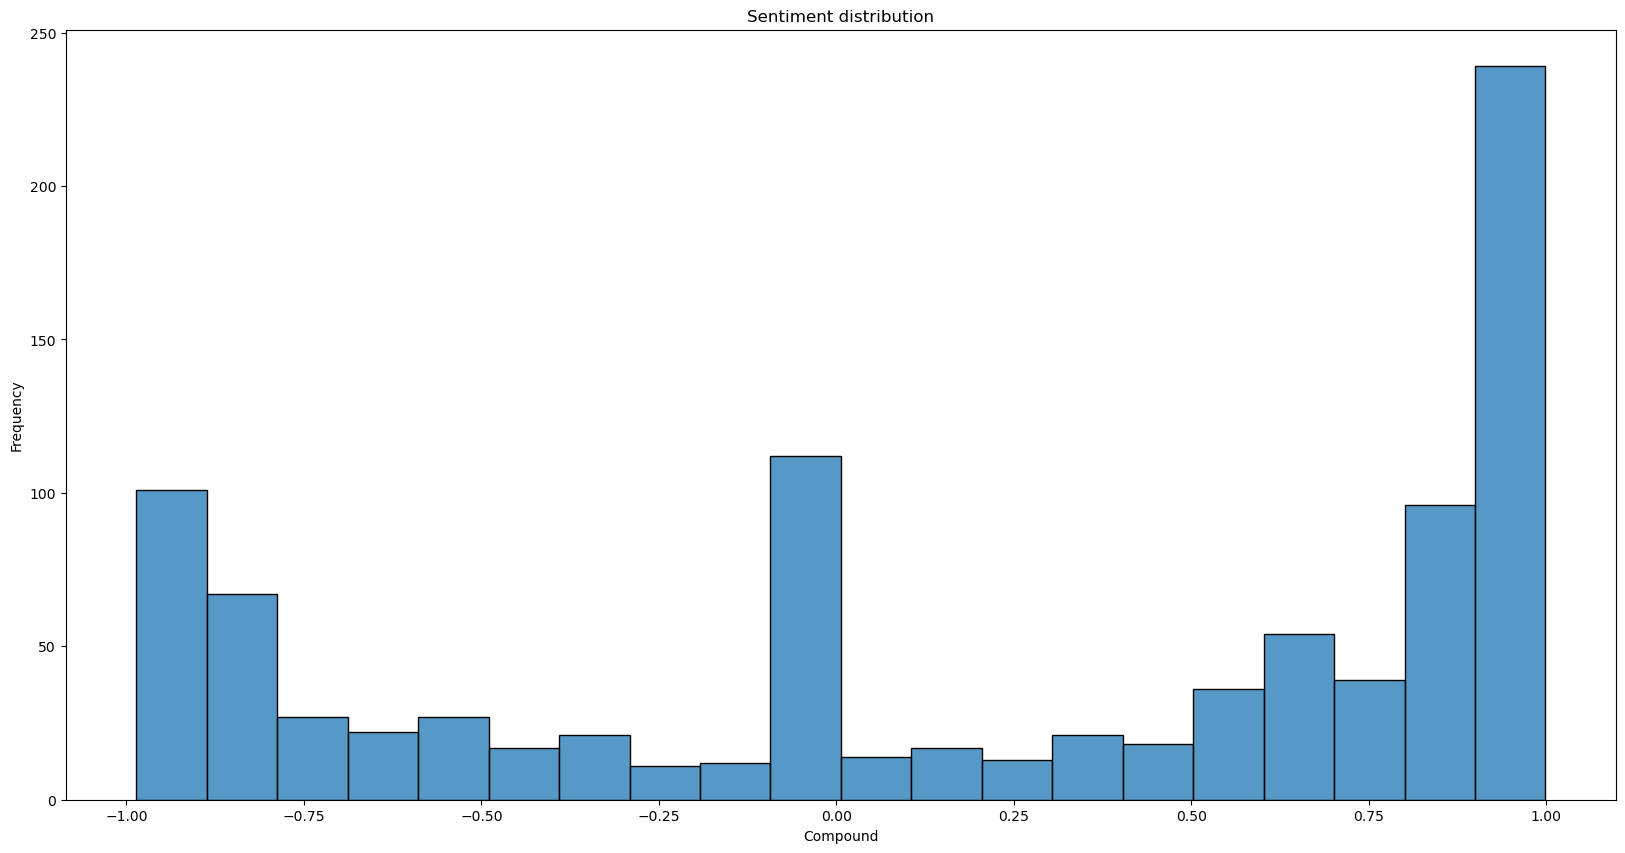

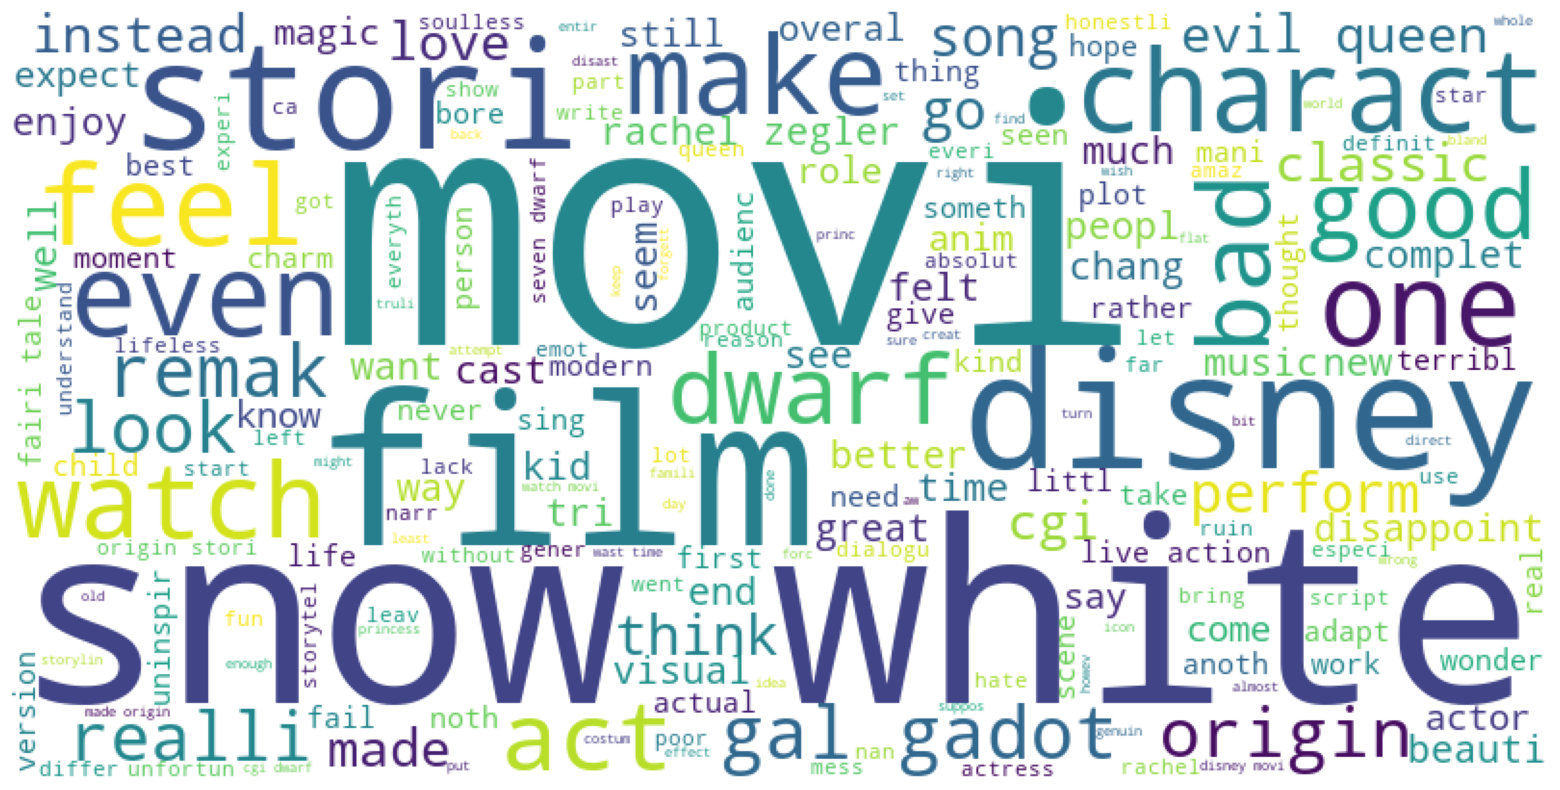

In [252]:
# Clean data
df = pd.read_csv("imdb.csv")
df['Cleaned_Review'] = df['Review'].astype(str).apply(tokenize)
df[['VADER_Compound', 'VADER_Positive', 'VADER_Negative', 'VADER_Neutral', 'Sentiment']] = df['Cleaned_Review'].apply(lambda x: pd.Series(analys(x)))
df.to_csv("imdb_clean.csv", index=False)

# Sentiment distribution
plt.figure(figsize=(20,10))
sns.histplot(df['VADER_Compound'], bins=20, edgecolor='black')
plt.title('Sentiment distribution')
plt.xlabel('Compound')
plt.ylabel('Frequency')
plt.show()

wcloud(' '.join(df['Cleaned_Review'].astype(str)))